In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from collections import Counter

In [2]:
class Skipgram(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super(Skipgram, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(self.vocabulary_size, self.embedding_size)
        self.linear1 = nn.Linear(self.embedding_size, self.vocabulary_size)

    
    def forward(self, input):
        embeds = self.embeddings(input)
        #print(embeds.shape)
        out = self.linear1(F.relu(embeds))
        log_probs = F.log_softmax(out, dim=1)
        
        return log_probs
    
    def get_embedding(self, input):
        out_vector = self.embeddings(input)
        return out_vector 
        

In [3]:
# import re

# def get_training_data(token_list, window_size, w2i, i2w):
#     training_data = []
#     for target_pos in range(len(token_list)):
#         # target_pos is the center position
#         target = token_list[target_pos]
#         contexts = []
#         for d in range(-window_size, window_size+1):
#             context_pos = target_pos + d
#             # skip target(center) token, avoid pos beyond token_list
#             if(context_pos == target_pos or context_pos < 0 or context_pos >= len(token_list)):
#                 continue
#             #print(context_pos)
#             #contexts.append(token_list[context_pos])
#             contexts.append(w2i[token_list[context_pos]])
# #         for i in range(window_size*2 - len(contexts)):
# #             contexts.append(w2i['None'])
#         training_data.append((contexts, w2i[token_list[target_pos]]))
#     return training_data

# def clean_data(token_list):
#     cleaned_list = []
#     for t in token_list:
#         cleaned_list.append(re.sub('0[xX][0-9a-fA-F]+', 'IMM', t))
#     return 

# def preprocess_data(filename, window_size):
#     with open(filename, "rb") as file:
#         text = file.read().decode('utf-8').strip()
#         text_split = text.split("\n")
#         # token is a line of assembly instruction
#         token_list = [' '.join(inst.split('\t')[1:]) for inst in text_split]
        
#         cleaned_token_list = clean_data(token_list)
        
        
#         vocab = set(token_list)
# #         vocab.add('None')
#         #print(vocab)
#         #print(len(vocab))
#         w2i = {word: i for i, word in enumerate(vocab)}
#         i2w = {i: word for word, i in w2i.items()}
#         #print(i2w)

#         training_data = get_training_data(token_list, window_size, w2i, i2w)
#     return vocab, training_data, w2i, i2w

# filename = "data/basename.c_main.c.o_main"
# vocab, training_data, w2i, i2w = preprocess_data(filename, 8)
#print(training_data)

In [22]:
import os
import re
import sys
def preprocess_token(token, threshold):
    print(token)
    sys.exit()
    #if "IMark" in token:
        #return ["IMARK"]
    #token_list = token.strip().split("=")
    #modified_list = []
    #print(token_list)
    #sys.exit()
#     for token in token_list:
#         new_token = re.sub('0[xX][0-9a-fA-F]+', 'MEM', token)
#         abs_values = re.findall('(?<=\s)\d+(?=\s|$)', new_token)
#         for v in abs_values:
#             # if absolute value is greater than threshhold, replace it with IMM
#             if(int(v) > threshold):
#                 new_token = new_token.replace(v, 'IMM')
#         modified_list.append(new_token)
#     return ' '.join(modified_list)
        


def preprocess_file(file):
    token_list = []
    with open(file, 'r') as f:
        tokens = f.readlines()
        for token in tokens:
            if "IMark" in token:
                #token = "IMark"
                continue
            elif "AbiHint" in token:
                #token = "AbiHint"
                continue
            else:
                # replace memory address
                token = re.sub('0[xX][0-9a-fA-F]+', 'MEM', token.strip())
                
                # replace offset constants
                token = re.sub('offset=\d+', 'offset=CONST', token)
                
                # replace temperary variable
                token = re.sub('t\d+', 'TVAR', token)
            #processed_token = preprocess_token(token, 1)
            token_list.append(token)
    return token_list

def collect_vocab(data_set):
    vocabs = {}
    for file, tokens in data_set.items():
        for token in tokens:
            if token not in vocabs:
                vocabs[token] = 1
            else:
                vocabs[token] += 1
    return vocabs

def min_frequency(dataset, vocabs, min_frequency):
    new_dataset = {}
    for file, tokens in dataset.items():
        new_tokens = tokens.copy()
        for token in tokens:
            #print(token)
            if(vocabs[token] < min_frequency):
                #print('remove {} {} {}'.format(file, token, vocabs[token]))
                new_tokens.remove(token)
        #print(tokens)
        new_dataset[file] = new_tokens
    return new_dataset

def get_dataset(data_dir):
    data_set = {}
    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            data_set[file] = preprocess_file(file_path)

    #print the dataset
    # for file, token_list in data_set.items():
    #     print(f'{file}: {token_list}')

    vocabs = collect_vocab(data_set)
    # for vocab, frequency in vocabs.items():
    #     print(vocab, frequency)

    processed_dataset = min_frequency(data_set, vocabs, 2)
    for file, tokens in processed_dataset.items():
        for token in tokens:
            if(vocabs[token] < 2):
                print(token, vocabs[token])

    w2i = {word: i for i, word in enumerate(vocabs.keys())}
    i2w = {i: word for word, i in w2i.items()}
    
    return processed_dataset, vocabs, w2i, i2w

data_set, vocabs, w2i, i2w = get_dataset('./vex2v_data_small/')
print(vocabs)

# for w, i in w2i.items():
#     print('{:<42}:{}'.format(w, i))
# print("=================")
# for file, tokens in data_set.items():
#     for token in tokens:
#         if(vocabs[token] < 2):
#             print(token, vocabs[token])

{'TVAR = GET:I64(offset=CONST)': 139555, 'TVAR = Sub64(TVAR,MEM)': 66342, 'PUT(offset=CONST) = TVAR': 227980, 'STle(TVAR) = TVAR': 80862, 'PUT(offset=CONST) = MEM': 427988, 'TVAR = Add64(TVAR,MEM)': 121956, 'TVAR = LDle:I64(TVAR)': 73614, 'TVAR = LDle:I32(TVAR)': 14068, 'TVAR = 32Uto64(TVAR)': 52669, 'TVAR = TVAR': 148517, 'TVAR = 64to32(TVAR)': 60897, 'TVAR = 64to32(MEM)': 9984, 'TVAR = CmpEQ32(TVAR,TVAR)': 7495, 'TVAR = 1Uto64(TVAR)': 36574, 'TVAR = 64to1(TVAR)': 37210, 'if (TVAR) { PUT(offset=CONST) = MEM; Ijk_Boring }': 35701, 'STle(TVAR) = MEM': 27283, 'TVAR = CmpEQ64(TVAR,MEM)': 12246, 'TVAR = LDle:I8(TVAR)': 51269, 'TVAR = GET:I8(offset=CONST)': 8717, 'TVAR = Add8(TVAR,TVAR)': 46754, 'TVAR = 8Uto64(TVAR)': 13893, 'TVAR = Shr64(TVAR,MEM)': 1824, 'TVAR = And32(TVAR,MEM)': 2248, 'TVAR = And64(TVAR,MEM)': 5256, 'TVAR = Or32(TVAR,MEM)': 218, 'TVAR = MullS64(TVAR,MEM)': 12, 'TVAR = 128HIto64(TVAR)': 144, 'TVAR = Sar64(TVAR,MEM)': 323, 'TVAR = Sub64(TVAR,TVAR)': 745, 'TVAR = Shl64(TVAR

In [ ]:
window_size = 8
batch_size = 250

def get_training_data(data_set, vocab, w2i, i2w, window_size):
    idx_pairs = []
    for file, tokens in data_set.items():
        indicies = [w2i[token] for token in tokens]
        for center_word_pos in range(len(indicies)):
            contexts = []
            for w in range(-window_size, window_size+1):
                context_word_pos = center_word_pos + w

                if context_word_pos < 0 or context_word_pos >= len(indicies) or center_word_pos == context_word_pos:
                    continue
                context_word_idx = indicies[context_word_pos]
                contexts.append(context_word_idx)
                #idx_pairs.append((indicies[center_word_pos], context_word_idx))
            idx_pairs.append([contexts, indicies[center_word_pos]])
    return idx_pairs

training_data = get_training_data(data_set, vocabs, w2i, i2w, window_size)
# print(training_data)
# batch_size

if(len(training_data) < batch_size):
    batch_size = len(training_data)//2

In [ ]:
def get_batch(data, batch_size):
    n_batches = len(data)//batch_size
    
    data = data[:n_batches*batch_size]
    for i in range(0, len(data), batch_size):
        x, y = [], []
        batch = data[i:i+batch_size]
        #print(batch)
        for j in range(len(batch)):
            y.extend(batch[j][0])
            x.extend([batch[j][1]]*len(batch[j][0]))
        yield x, y

# get_batch(training_data, batch_size)

In [ ]:
if(len(training_data) < batch_size):
    batch_size = len(training_data)//2

# training
losses = []
loss_function = nn.NLLLoss()
embedding_size = 100
model = Skipgram(len(vocabs), embedding_size)
print(len(vocabs))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epoch = 20

for e in range(epoch):
    total_loss = 0
    for center, context in get_batch(training_data, batch_size):
        #print(center)
        input_ = torch.LongTensor(center)
        label = torch.LongTensor(context)
        #print(input_)
        log_probs = model(input_)
        loss = loss_function(log_probs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss
    print('{}/{}'.format(e, epoch))
    losses.append(total_loss)

In [ ]:
print(losses)

In [9]:
# training_data

In [10]:
# print('len(training_data): ', len(training_data))

In [11]:
# import numpy as np

In [12]:
# losses = []
# loss_function = nn.NLLLoss()
# model = Skipgram(len(vocab), 100, 8)
# print(len(vocab))
# optimizer = optim.SGD(model.parameters(), lr=0.001)
# epoch = 200
# training_data = np.array(training_data)
# #print(i2w[47])

# for e in range(epoch):
#     if e%20 == 0:
#         print(f"epoch {e}/{epoch-1}")
#     total_loss = 0
#     i = 0
#     for contexts, center in raw_training_data:
#         #print(context)
#         input_ = torch.tensor([center], dtype=torch.long)
#         log_probs = model(input_)
        
#         y_true = torch.tensor([context], dtype=torch.long)
#         #y_true[w2i[context]] = 1
#         model.zero_grad()
#         loss = loss_function(log_probs, y_true)
#         loss.backward()
#         optimizer.step()
#         total_loss+=loss
#     losses.append(total_loss)
# #         input_layer = np.zeros(len(vocab))
# #         input_layer[target] = 1.0
# #         input_layer = torch.tensor(input_layer, dtype=torch.long)
        
# #         output = torch.tensor(np.array(contexts), dtype=torch.long)
        
# #         log_probs = model(input_layer)
#           #print(contexts, target)
# #         context_idxs = torch.tensor([[target] for context in contexts], dtype=torch.long)
# #         model.zero_grad()
# #         #print(context_idxs)
# #         log_probs = model(context_idxs)
# #         #print(log_probs)
# #         context_list = torch.tensor([context for context in contexts], dtype=torch.long)
# #         #print(context_list)
# #         loss = loss_function(log_probs, context_list)
        
# #         loss.backward()
# #         optimizer.step()
        
#         #total_loss+=loss.item()
#     #losses.append(total_loss)
# #print(losses)
    
    


In [13]:
# from tqdm import tqdm_gui
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

Text(0.5, 0, 'Epoch')

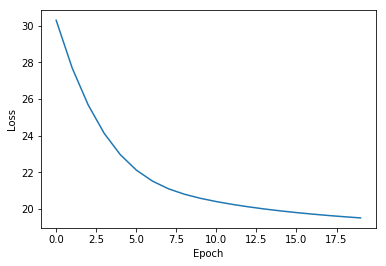

In [14]:
plt.plot(range(epoch), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [15]:
EMBEDDINGS = model.embeddings.weight.data
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

print('\n', 'running TSNE...')
tsne = TSNE(n_components = 2).fit_transform(EMBEDDINGS)
print('tsne.shape: ', tsne.shape) #(15, 2)

EMBEDDINGS.shape:  torch.Size([41, 100])

 running TSNE...
tsne.shape:  (41, 2)


41


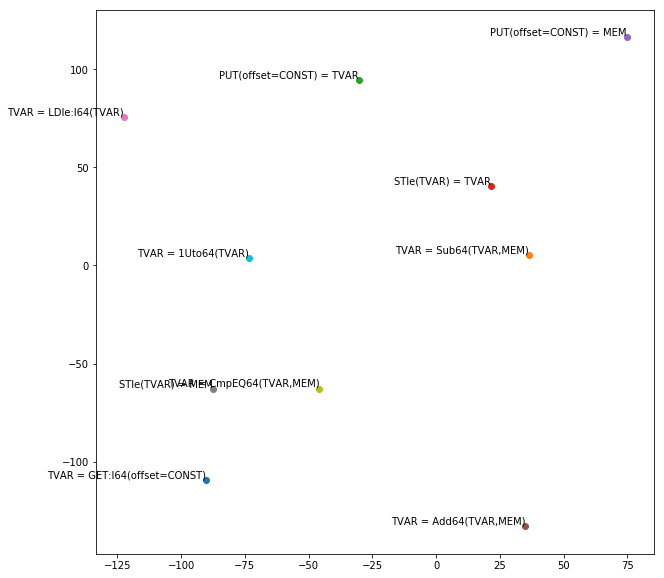

In [21]:
############ VISUALIZING ############
x, y = [], []
annotations = []
print(len(tsne))
for idx, coord in enumerate(tsne):
    # print(coord)
    #print(idx)
    annotations.append(i2w[idx])
    x.append(coord[0])
    y.append(coord[1])   

test_words = list(vocabs)[:10]

plt.figure(figsize = (10, 10))
for i in range(len(test_words)):
    word = test_words[i]
    vocab_idx = w2i[word]
    plt.scatter(x[vocab_idx], y[vocab_idx])
    plt.annotate(word, xy = (x[vocab_idx], y[vocab_idx]), \
        ha='right',va='bottom')

plt.savefig("w2v.png")
plt.show()

In [20]:
model.get_embedding(torch.tensor(w2i['TVAR = Or32(TVAR,MEM)'], dtype=torch.long))

tensor([-1.3151e+00,  9.0829e-01, -8.1870e-01, -6.6202e-01, -8.6307e-02,
         1.3051e+00, -1.6273e+00,  4.1035e-01, -4.6328e-01,  4.6987e-01,
        -1.5555e+00, -6.3077e-01,  8.4798e-01,  4.2594e-01, -5.6145e-01,
         8.7692e-01, -2.3805e+00, -9.8229e-02,  2.0519e+00, -2.2942e+00,
        -1.2603e+00,  7.9519e-01, -5.6429e-01, -7.9104e-01, -3.3979e-01,
         3.9079e-02,  9.7181e-01,  9.9036e-01, -9.3822e-01, -2.5219e-01,
        -7.2200e-01, -3.1945e-01, -1.8064e+00, -4.2615e-01,  1.1011e+00,
        -1.1332e+00,  8.4135e-01,  1.2083e+00, -1.2794e+00,  2.4672e-01,
        -3.5978e-01, -7.3117e-01, -1.9316e+00,  2.3333e+00,  1.0991e+00,
        -1.2457e+00, -9.2255e-01,  7.5578e-02, -1.7042e+00, -2.1481e-01,
         1.5988e+00,  1.3483e+00,  5.6416e-01, -9.9314e-01, -3.8192e-01,
         7.0234e-04,  7.1779e-01, -1.2918e-01,  1.1327e+00, -1.1780e+00,
         1.2631e+00, -3.2357e-01, -8.8209e-01,  1.0900e+00,  6.5616e-02,
        -1.9300e+00,  2.2434e-02, -2.2821e+00,  5.1

In [93]:
torch.cuda.is_available()

False

TypeError: 'module' object is not callable